# Using Deep Learning to Predict Numerical Values using Antibody Thermostability as an Example

### Questions:

- How may we use a deep learning predictor to predict numerical values

- How can we measure the accuracy of the deep learning predictor?


### Objectives:
    
- Use encoded antibody protein sequences to train a deep learning predictor to predict antibody thermostability.

- Measure the accuracy of the deep learning model.

- Improve the accuracy of the deep learning model.

### Introduction 

In this example we will look at antibody sequences and their thermostabilities to demonstrate how how deep learning algorithms may calculate a numerical score rather than a classification. Antibodies are made up of two heavy and two light chains, however, the functional antigen-binding domains are Fv fragments at each fork of the "Y" shape. These Fv fragments are where the VH domain of a heavy chain and VL domain of a light chain interact and so much study has been dedicated to these regions. An antibody record is considered "paired" when both the VH and VL sequences of one antibody are known. This knowledge was rare in the past and came from studying individual antibodies, however, the advent of B-cell encapsulation and Next Generation Sequencing now allowed researchers to sequence a repertoire of paired antibodies (Rajan *et al.*, 2018).


In order to train a model to predict the $\Delta$ G of Unfolding of antibodies, we have to encode our sequences into numerical values that capture meaningful representations of the strings. We will be doing this using the Propythia module (Sequeira *et al.*, 2022) which calculates physiochemical properties from the sequences for both the VH and VL domains of the anitbodies. This data will then be used to train a deep learning model.

We took 8390 human antibody sequences taken from the Observed Antibody Space (Olsen *et al.*, 2022) and calculated their thermostabilities using the method developed by Oobatake (1993). This represents the antibody's thermostability as the $\Delta$ G of Unfolding where positive values represent a higher thermostability, and negative values represent a low thermostability where the protein is likely to unfold spontaneously. By using these values as a validation set for training, we can then obtain predicted thermostabilities as our output.


### References


Olsen, T. H., Boyles, F., & Deane, C. M. (2022). Observed Antibody Space: A diverse database of cleaned, annotated, and translated unpaired
and paired antibody sequences. Protein Science, 31(1), 141–146. https://doi.org/https://doi.org/10.1002/pro.4205

Oobatake, M., & Ooi, T. (1993). Hydration and heat stability effects on protein unfolding. Progress in Biophysics and Molecular Biology, 59(3), 237–284. https://doi.org/10.1016/0079-6107(93)90002-2

Sequeira, A. M., Lousa, D., & Rocha, M. (2022). ProPythia: A Python package for protein classification based on machine and deep learning.
Neurocomputing, 484, 172–182. https://doi.org/https://doi.org/10.1016/j.neucom.2021.07.102




## Imports and Requirements
The antibody encoding method we will be using is the Propythia program. Before starting we recommend installing it by copying and pasting the following command in your terminal/command line:

`pip install propythia`

The machine learning models that we will use are imported from the Keras package. We also suggest installing this via the following command: 

`pip install keras`

As this is a large package, rather than importing the whole package, it is better practise to just import the fuctions we require. As this usually leaves with a lot of import statements, we have broken them down what imports are required at what stage of the process.

In [3]:
##Get Encodings##
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import sys
from pandas import read_csv
sys.path.append('../src/')
sys.path.append('')
from propythia.sequence import ReadSequence
sequence=ReadSequence()
from propythia.descriptors import Descriptor
from numpy import mgrid, linspace, c_, arange, mean, array
from numpy.random import uniform, seed

##Data Preprocessing##
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.utils import shuffle


##Deep Learning Models###
from keras.models import Sequential
from keras.layers import Dense
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RepeatedKFold

##Evaluating Results and Plotting##
from sklearn import metrics
from sklearn.metrics import make_scorer
from pandas import read_csv
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits import mplot3d
from matplotlib.pyplot import subplots, axes, scatter, xticks
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from sklearn.feature_selection import f_regression

AttributeError: module 'importlib_metadata' has no attribute 'entry_points'

In [15]:
###Propythia Command to get encodings###

def get_descriptors(protein):
    # creating object to calculate descriptors
    # all except tripeptide and binaries representations, nlf and blosum encodings
    #test=protein.get_all(tricomp=False, bin_aa=False, bin_prop=False) 
    test= protein.adaptable([3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21])
    return(test)

In [13]:
def Get_dataset(fasta):
    VH_sequences = []
    VL_sequences = []
    with open(fasta, "r") as f:
        for line in f:
            if line[0] == ">":
                if "_VH" in line:
                    sequence_to_add = f.readline().strip()
                    VH_sequences.append(sequence_to_add)
                elif "_VL" in line:
                    sequence_to_add = f.readline().strip()
                    VL_sequences.append(sequence_to_add)

    print(len(VH_sequences),len(VL_sequences))
    if len(VH_sequences) == len(VL_sequences):
        VH_dataframe = pd.DataFrame()
        VL_dataframe = pd.DataFrame()
        for i in range(len(VH_sequences)):
            ps_string=sequence.read_protein_sequence(VH_sequences[i])
            protein = Descriptor(ps_string)
            descriptors = get_descriptors(protein)
            VH_dataframe = VH_dataframe.append(descriptors, ignore_index=True)
        print("VH_data", VH_dataframe.shape)
        for i in range(len(VL_sequences)):
            ps_string=sequence.read_protein_sequence(VL_sequences[i])
            protein = Descriptor(ps_string)
            descriptors = get_descriptors(protein)
            VL_dataframe = VL_dataframe.append(descriptors, ignore_index=True)
        print("VL_data", VL_dataframe.shape)
    # Now we join these two dataframes together so that each sample now has information about its VH and VL sequence.
    VH_dataframe_suffix = VH_dataframe.add_suffix('_VH')
    VL_dataframe_suffix = VL_dataframe.add_suffix('_VL')
    joined_dataframe_VH_VL =  VH_dataframe_suffix.join(VL_dataframe_suffix)
    return(joined_dataframe_VH_VL)


## Generating the Encoded Dataset
Here we input our fasta file and split the entries into VH and VL sequences. We put each set of sequecnes through the Propythia encoder a dataframe of numerical information for both VH and VL sequences.

In [ ]:
### Input Fasta and Run Dataset###

encodings = read_csv('./Delta_G_2000_Human_seq_encodings.csv', header=0)
Delta_G_Values = read_csv('./Delta_G_Values.csv', header = 0)
print(encodings.shape)

In [8]:

X = encodings
y = Delta_G_Values
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0, shuffle=True)


(8394, 891) (8394, 1)


## Build Deep Learning Model
Now we have our training data, we can build our deep learning models. In this case, we will use an artificial neural network (ANN) to answer our question. This model is a unidirectional function whereby an input dataset is moved through a series of layers of nodes (or neurons), whereby an operation is performed to the input of each node. There is not a lot of code required to build an ANN, but it does requires some consideration of the data you have, and what answers you are trying to get out of it. While they can be used for binary classification they are also used to return a score. The model will usually start with the number of input features as your input data and it will be decreased as it does through the model. 

Below we use a simple model topogrophy of three hidden layers with 891 input nodes, the next layers of 64, 32 and 8 nodes, and one output, which will be our prediction. These layers are Dense, meaning each node of the that layer will have a connection to each node to the previous layer. Each hidden layer has an activation function which defines how each node calculates its output from its inputs. For our example, we use 'relu', or Rectified Linear Unit activation function, which is a non-saturating activation function that allows modelling of non-linear and interaction effects, and usually has better performance than Sigmoid or Tanh functions. However, Sigmoid functions are very useful in cases where we want to make binary classifiers with ANNs. The final layer of the model should have as many nodes as you expect to get out. In most cases this will only be a single layer. More information on activation functions may be found [here](https://keras.io/api/layers/activations/)

The model must then be compiled and an optimizer selected. Our chosen optimizer is 'adam', which takes advantage of an adaptive learning gradient, rather than using a single learning rate like other optimizers. More information on optimizers can be found [here](https://keras.io/api/optimizers/).

In [1]:
##Function to build models##
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(8,activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam')
    return model



In [10]:
##Build model##
model = get_model(X.shape[1], 1)
##Fit model##
model.fit(X_train, y_train, verbose=2, epochs=200)
mae = model.evaluate(X_test, y_test, verbose=0)


2022-10-31 11:04:14.766864: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
184/184 - 1s - loss: 3351.9570 - 841ms/epoch - 5ms/step
Epoch 2/200
184/184 - 0s - loss: 3257.0312 - 460ms/epoch - 2ms/step
Epoch 3/200
184/184 - 0s - loss: 3237.7917 - 294ms/epoch - 2ms/step
Epoch 4/200
184/184 - 0s - loss: 3236.3003 - 363ms/epoch - 2ms/step
Epoch 5/200
184/184 - 0s - loss: 3233.0115 - 387ms/epoch - 2ms/step
Epoch 6/200
184/184 - 0s - loss: 3222.5715 - 336ms/epoch - 2ms/step
Epoch 7/200
184/184 - 0s - loss: 3210.5999 - 332ms/epoch - 2ms/step
Epoch 8/200
184/184 - 0s - loss: 3206.7244 - 353ms/epoch - 2ms/step
Epoch 9/200
184/184 - 0s - loss: 3195.4656 - 345ms/epoch - 2ms/step
Epoch 10/200
184/184 - 0s - loss: 3179.5752 - 403ms/epoch - 2ms/step
Epoch 11/200
184/184 - 0s - loss: 3185.4258 - 344ms/epoch - 2ms/step
Epoch 12/200
184/184 - 0s - loss: 3164.0242 - 379ms/epoch - 2ms/step
Epoch 13/200
184/184 - 0s - loss: 3133.0471 - 419ms/epoch - 2ms/step
Epoch 14/200
184/184 - 0s - loss: 3114.2510 - 341ms/epoch - 2ms/step
Epoch 15/200
184/184 - 1s - loss: 3078.7800

With our model trained and tested. Now we can use it to predcit the $\delta$G values of the testing portion of our dataset. These results can then be stored in an array and plotted against their actual values as a measure of the success of our predictor. Upon plotting the results, we would expect to see a linear relationship between the observed and expected results with a high correlation coefficient.

(2519, 891)
[[1.        0.9796116]
 [0.9796116 1.       ]]


Text(0, 0.5, 'Observed delta G of Unfolding')

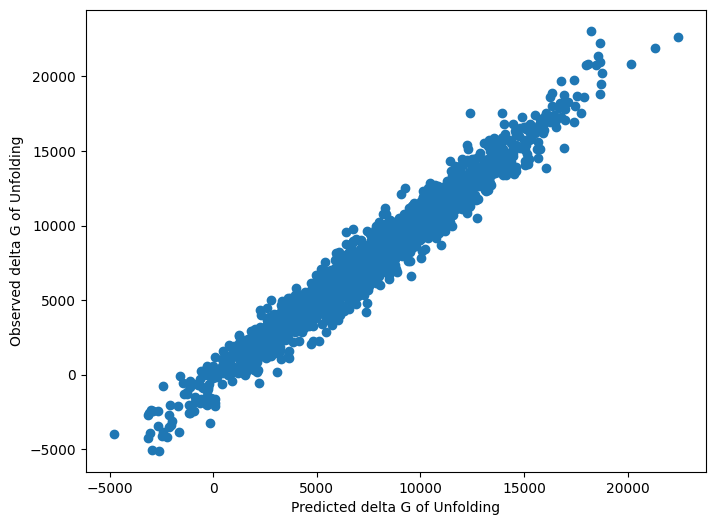

In [11]:
#Store Outputs#
predicted_results = []
observed_results  = []
maes = []

prediction = model.predict(X_test)
numpy_y_test = (y_test.to_numpy())
predictions = prediction.tolist()
predictions = [item for sublist in predictions for item in sublist]
validations = numpy_y_test.tolist()
validations = [item for sublist in validations for item in sublist]

fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(predictions, validations)
correlation_coefficient = np.corrcoef(predictions,validations )
print("Correlation coefficient:", correlation_coefficient[0][1])

ax.set_xlabel('Predicted delta G of Unfolding')
ax.set_ylabel('Observed delta G of Unfolding')

## Testing on a Naive Dataset
Now we can try out our model on a totally naive dataset by encoding our data in the same way as our input dataset

In [16]:
### Input Fasta and Run Dataset###
Naive_fasta = './all_test.faa.txt'
naive_encodings = Get_dataset(Naive_fasta)
print(naive_encodings.shape)


360 360
VH_data (360, 445)
VL_data (360, 445)
(360, 890)


In [42]:
Naive_predicted_results = []
Naive_observed_results  = []
naive_prediction = model.predict(naive_encodings)
Naive_observed_results = (y_test.to_numpy())
print(naive_prediction)
print(Naive_observed_results)
#predictions = prediction.tolist()
#predictions = [item for sublist in predictions for item in sublist]
#validations = numpy_y_test.tolist()
#validations = [item for sublist in validations for item in sublist]



ValueError: in user code:

    File "/Users/james/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/Users/james/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/james/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/james/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/Users/james/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/james/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 891), found shape=(None, 890)


## End of Chapter Exercises


There are many more properties of antibodies, or any protein that we could train an ANN to predict. For instance, we can use isoelectrisity as another example. Isoelectrisity (pI) is the pH which a protein requires to have a net charge of zero. Usually this is around 6-7, but more charged proteins may have either higher or lower values of pI. In the material for this worksheet, another file containing the pI values for all of the antibodies used in this workbook. Generate a new ANN predictor to demonstrate that this property may be calculated from our encoded antibodies too.

- Demonstrate the linear relationship between predicted and observed results.